In [5]:
#CONDA ENV pytorch1 (python 3.9.7)
#Import packages
#---------------------------------------
import sys
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool
import process_functions as pf
import pyBigWig as bw
import torch
from enformer_pytorch import Enformer, GenomeIntervalDataset
import polars as pl

#Import your modules
#---------------------------------------
sys.path.insert(1, '/cndd3/dburrows/CODE/admin_tools/')
from admin_tools import admin_functions as adm

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
s_fig = '/cndd3/dburrows/FIGS/'

%load_ext autoreload
print(f'Python version {sys.version}')
print(f'Python path {sys.executable}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
Python path /home/dburrows/mambaforge/envs/pytorch1/bin/python


In [48]:
#Load in data
splice = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/SJ.comb.bed', sep='\t', index_col=0)
splice.index = splice['id-unique'] #set spliceid as index
mcg = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/CG.bingraph.raw', sep='\t', index_col=0)
mch = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/CAC.bingraph.raw', sep='\t', index_col=0)
atac = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/ATAC.bingraph.raw', sep='\t', index_col=0)

/tmp/ipykernel_2642216/823340253.py:2: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  splice = pd.read_csv('/cndd2/dburrows/DATA/splice/model/processed_data/SJ.comb.bed', sep='\t', index_col=0)


In [196]:
#Deal with nans
print(f'{np.ceil((sum(np.sum(np.isnan(mcg).values,axis=1) > 0) / len(mcg))*100)}% of SJs contain mcg nans') 
print(f'{np.ceil((sum(np.sum(np.isnan(mch).values,axis=1) > 0) / len(mch))*100)}% of SJs contain mch nans') 

14.0% of SJs contain mcg nans
2.0% of SJs contain mch nans


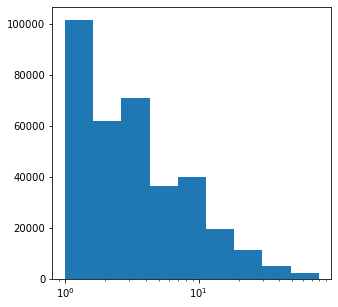

In [241]:
#plot number of nans in mcg

curr = mcg.values
sum_nan = np.sum(np.isnan(curr),axis=1)
fig,ax = plt.subplots(figsize=(5,5))
plt.hist(sum_nan,bins=np.geomspace(1,np.max(sum_nan),10))
plt.xscale('log')
plt.show()

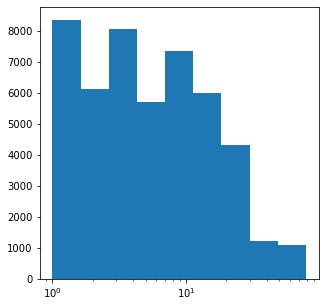

In [239]:
#plot number of nans in mch
curr = mch.values
sum_nan = np.sum(np.isnan(curr),axis=1)
fig,ax = plt.subplots(figsize=(5,5))
plt.hist(sum_nan,bins=np.geomspace(1,np.max(sum_nan),10))
plt.xscale('log')
plt.show()

In [256]:
#impute nans
loc = np.where(np.isnan(mcg.values)==True)
loc

(array([      6,       6,       6, ..., 2523445, 2523445, 2523445]),
 array([ 4, 26, 47, ..., 65, 66, 67]))

In [269]:
left = loc[0]-1,loc[1]-1
right = loc[0]+1,loc[1]+1

left,right

((array([      5,       5,       5, ..., 2523444, 2523444, 2523444]),
  array([ 3, 25, 46, ..., 64, 65, 66])),
 (array([      7,       7,       7, ..., 2523446, 2523446, 2523446]),
  array([ 5, 27, 48, ..., 66, 67, 68])))

In [271]:
mcg.values[left]

array([0.2697  , 0.83932 , 0.116225, ...,      nan,      nan, 0.9091  ])

In [272]:
mcg.values[right]

IndexError: index 79 is out of bounds for axis 1 with size 79

In [252]:
mcg.values[np.isnan(mcg.values)]

array([nan, nan, nan, ..., nan, nan, nan])

In [160]:
#Instantiate dataset object
prac = episplice_dataset(splice=splice['CPM'], mcg=mcg, mch=mch, 
                         atac=atac, pos_enc = (mcg.columns.values).astype(float), mode='binned')

In [164]:
mc_sum = np.sum(mcg,axis=1)
mc_sum

L2-3_ITchr11000013810003234-acceptor    64.986165
L2-3_ITchr11000013810003234-donor       62.254174
L2-3_ITchr11000013810009071-acceptor    64.986165
L2-3_ITchr11000013810009071-donor       40.514534
L2-3_ITchr11000345410009071-acceptor    61.534634
                                          ...    
Lamp5chrX75997367600620-donor           60.173471
Lamp5chrX76007547604159-acceptor        59.774292
Lamp5chrX76007547604159-donor           57.052710
Lamp5chrX76043387605243-acceptor        57.153712
Lamp5chrX76043387605243-donor           53.917631
Length: 2523478, dtype: float64

In [190]:
sum(np.sum(np.isnan(mcg).values,axis=1) > 0)

349690

In [194]:
np.ceil((sum(np.sum(np.isnan(mcg).values,axis=1) > 0) / len(mcg))*100)

14.0

In [191]:
len(mcg)

2523478

In [161]:
class episplice_dataset(Dataset):
    """Dataset class for Pytorch Lightning neural network models. Epi datasets will be loaded as continuous traces. 

    Datatypes:
        splice (dataframe): all SJ usage values, indexed by unique SJ id.
        seq ???
        mcg (dataframe): all binned mcg values containing flanking context of SJ, indexed by unique SJ id. Bin labels in columns must match mcg and atac, and be the same across all SJs. 
        mch (dataframe): all binned mch values containing flanking context of SJ, indexed by unique SJ id. 
        atac (dataframe): all binned atac values containing flanking context of SJ, indexed by unique SJ id. 
        pos_enc (array): labels of positional encodings for flanking epi bins.  
        mode (str): 'continuous' for loading continous epi traces, 'binned' for loading mean binned values for epi traces (used for MLP baseline) 

    """

    def __init__(self,splice=None, seq = None, mcg=None, mch=None, atac=None, pos_enc=None, mode='continuous'):
        """ Initialise epigenetic splice dataset """
        self.splice = splice
        self.seq = seq
        self.mcg = mcg
        self.mch = mch
        self.atac = atac
        self.pos_enc = pos_enc
        self.mode = mode
        if seq is None and mcg is None and mch is None and atac is None: 
            raise Exception('At least one datatype must be entered to make predictions')
            
        if mode != 'continuous' and mode != 'binned':
            raise Exception('Mode must be either continuous or binned')
            
        
    def __len__(self):
        """ Return length of dataset """
        return len(self.splice)
    
    
    def __getitem__(self,idx):
        """ Return splice, seq, mcg, mch, atac at index """
        splice_idx, seq_idx, mcg_idx, mch_idx, atac_idx,pos_enc_idx = None,None,None,None,None,None
        
        #access SJ usage and convert to tensor
        if self.splice is not None: splice_idx = torch.tensor(self.splice.loc[idx], dtype=torch.float32)
        
        #output each feature separately
        if self.mode == 'continuous':
            #slice and convert to tensor
            if self.seq is not None: seq_idx = None #TBD
            if self.mcg is not None: mcg_idx = torch.tensor(self.mcg.loc[idx].values, dtype=torch.float32)
            if self.mch is not None: mch_idx = torch.tensor(self.mch.loc[idx].values, dtype=torch.float32)
            if self.atac is not None: atac_idx = torch.tensor(self.atac.loc[idx].values, dtype=torch.float32)
            if self.pos_enc is not None: pos_enc_idx = torch.tensor(self.pos_enc, dtype=torch.float32)

            return(splice_idx,seq_idx, mcg_idx, mch_idx, atac_idx, pos_enc_idx)
        
        #output single vector for MLP
        if self.mode == 'binned':
            if mcg is None or mch is None or atac is None: 
                raise Exception('All epi data (mcg, mch, atac) required for binned Dataset object')
            
            nbins=10
            it = np.append([(len(self.mcg.loc[idx].values)//nbins)*i for i in range(nbins+1)], len(self.mcg.loc[idx].values)) #split indeces by 10
            mcg_idx = [np.mean(self.mcg.loc[idx].values[it[i]:it[i+1]]) for i in range(len(it)-1)]
            mch_idx = [np.mean(self.mch.loc[idx].values[it[i]:it[i+1]]) for i in range(len(it)-1)]
            atac_idx = [np.mean(self.atac.loc[idx].values[it[i]:it[i+1]]) for i in range(len(it)-1)]
            return(splice_idx, torch.tensor(mcg_idx + mch_idx + atac_idx, dtype=torch.float32))
                
        

In [18]:
#DATALoader? 


1

In [ ]:
#model object shell

In [ ]:
#specific architecture -> learn about MLP

#32 -> 32 -> 16 -> 1
# multiple of 8? why? 

In [ ]:
#training etc. run

#train,test,val
# batch, test , use val to look at performance at each step, 
# if overfitting early on, too many units, and vice versa 

In [ ]:
"""Dataset and DataLoader classes for Pytorch Lightning neural network models.

Dataset types:

- TabularDataset: for tabular data. Converts two pandas DataFrames (X and y)
	  to a Pytorch Dataset. Indices are used to match X and y.

- CoordScalingTabularDataset: for tabular data with coordinate scaling. All
	columns that contain 'coord' in the name will be scaled by a factor of
	100,000 (e.g. 600,000 becomes 6). This is useful for scaling the east
	and north coordinates in the UKBB dataset which range from about 0 to
	1.2 million.
"""




class TabularDataset(Dataset):
	"""Tabular dataset for Pytorch neural network models.

	Args:
		X: pandas DataFrame, features
		y: pandas Series, target
	"""

	def __init__(self, X, y=None):
		"""Initialize tabular dataset."""
		self.X = X
		self.y = y

	def __len__(self):
		"""Return length of dataset."""
		return len(self.X)

	def __getitem__(self, idx):
		"""Return X and y at index."""
		if self.y is not None:
			return (
				torch.tensor(self.X.iloc[idx].values, dtype=torch.float32), 
				torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)
			)
		else:
			return torch.tensor(self.X.iloc[idx].values, dtype=torch.float32)
		



In [3]:
"""Dataset and DataLoader classes for Pytorch Lightning neural network models.

Dataset types:

- TabularDataset: for tabular data. Converts two pandas DataFrames (X and y)
	  to a Pytorch Dataset. Indices are used to match X and y.

- CoordScalingTabularDataset: for tabular data with coordinate scaling. All
	columns that contain 'coord' in the name will be scaled by a factor of
	100,000 (e.g. 600,000 becomes 6). This is useful for scaling the east
	and north coordinates in the UKBB dataset which range from about 0 to
	1.2 million.
"""



class TabularDataset(Dataset):
	"""Tabular dataset for Pytorch neural network models.

	Args:
		X: pandas DataFrame, features
		y: pandas Series, target
	"""

	def __init__(self, X, y=None):
		"""Initialize tabular dataset."""
		self.X = X
		self.y = y

	def __len__(self):
		"""Return length of dataset."""
		return len(self.X)

	def __getitem__(self, idx):
		"""Return X and y at index."""
		if self.y is not None:
			return (
				torch.tensor(self.X.iloc[idx].values, dtype=torch.float32), 
				torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)
			)
		else:
			return torch.tensor(self.X.iloc[idx].values, dtype=torch.float32)
		

class CoordScalingTabularDataset(TabularDataset):
	"""Tabular dataset for Pytorch neural network models with coordinate scaling.

	All columns that contain 'coord' in the name will be scaled by a factor of
	100,000 (e.g. 600,000 becomes 6). This is useful for scaling the east and
	north coordinates in the UKBB dataset which range from about 0 to 600,000.
	"""

	def __init__(self, X, y=None):
		"""Initialize tabular dataset."""
		# Scale coordinates
		for col in X.columns:
			if 'coord' in col:
				X[col] = X[col] / 100000

		super().__init__(X, y)

Note: you may need to restart the kernel to use updated packages.
